![banner](/custom/banner.png)


# FSLeyes Jupyter notebook


## Help


Use the built-in `help` function to get help on anything in the shell
environment, whether it is a module, function, class, or object:

    help(load)



## Overlays


The `overlayList` is a list which contains all of the overlays that have been
loaded into FSLeyes.  You can load overlays by using the `load` function,
e.g.:

    std = load('MNI152_T1_2mm.nii.gz')


You can remove an overlay simply by removing it from the `overlayList`:

    del overlayList[0]


## Display settings


You can use the `displayCtx` to access the display settings for an
overlay. Display settings for an overlay are divided between two objects:

 - A `Display` object, which contains general display settings
 - A `DisplayOpts` object, which contains display settings specific to the
   overlay type


You can access these objects like so:

    overlay = overlayList[0]
    display = displayCtx.getDisplay(overlay)
    opts    = displayCtx.getOpts(   overlay)


Then adjusting the overlay display settings is easy:


    display.brightness = 75
    opts.cmap          = 'hot'


## FSL commands


Many FSL commands can be called through Python functions, e.g.:

    flirt('src.nii.gz', 'ref.nii.gz', applyxfm=True, init='src2ref.mat')


For commands which produce output images, you can have the outputs loaded
directly into FSLeyes by using the special `LOAD` symbol:

    struc = Image('struct.nii.gz')
    bet(struc, LOAD)


To submit a command as a cluster job, use the `submit` flag:

    fnirt('src.nii.gz', 'ref.nii.gz', submit=True)


## User interface


You can access the current views in FSLeyes through the ``frame`` object:

    ortho = frame.viewPanels[0]


You also can add/remove views through the ``frame``:


    frame.removeViewPanel(ortho)
    frame.addViewPanel(Scene3DPanel)


## Screenshots


To insert a screenshot of the currently displayed scene into the notebook, use
the `screenshot` function:

    ortho = frame.viewPanels[0]
    screenshot(ortho)


## Reproducing a scene


The `getState` function returns a string which describes the current FSLeyes
state. This string describes the current FSLeyes user interface (views,
controls, and toolbars) as well as all loaded overlays and their display
settings.


You can also use the `setState` function to reproduce a previously generated
FSLeyes state.


To make your notebook reproduce your FSLeyes setup, set up your user interface
and overlays how you want, and then call `getState` to get a description of
the current FSLeyes setup:


    getState()


Now copy the string that `getState` generates, and then at the top of your
notebook add a call to `setState`, passing in that string, e.g.:

    fsleyesState = 'OrthoPanel\nlayout2|name=OrthoPanel 1;caption=...'
    setState(fsleyesState)


## For more information

See the FSLeyes and `fslpy` API documentation:

 - https://open.win.ox.ac.uk/pages/fsl/fsleyes/fsleyes/apidoc/
 - https://open.win.ox.ac.uk/pages/fsl/fslpy/

### 1. Load data and visualization

In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt



def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)

In [5]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 13.3 MB/s eta 0:00:000:00:01
  Obtaining dependency information for aiohttp>=3.8.4 from https://files.pythonhosted.org/packages/34/97/d042349afcad79d7c813b07e34cb3a6f0024b4faf07346509b115fe19f97/aiohttp-3.8.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 20.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 29.1 MB/s eta 0:00:00
  Obtaining dependency information for async-timeout<5.0,>=4.0.0a3 from https://files.pythonhosted.org/packages/a7/fa/e01228c2938de91d47b307831c62ab9e4001e747789d0b05baf779a6488c/async_timeout-4.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 58.1 MB/s eta 0:00:00
  Obtaining dependency information for frozenlist>=1.1.1

  Created wheel for pygltflib: filename=pygltflib-1.16.1-py3-none-any.whl size=27088 sha256=2fcb5d23a2469e9db1843095ff00a488c14f42f3250872043c6183a262443491
  Stored in directory: /home/ffriedli/.cache/pip/wheels/6b/4b/63/55a9ae1f622d1e51ba669abd1d129dc585a88d217d5227e987
Successfully built pygltflib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 9.3 MB/s eta 0:00:00


In [6]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.viz import regtools
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

In [7]:
#loading the data
subject = '02' 

# load each data
sample_path2 = "miniproject_ica_events"
sample_path3 = "miniproject_icafunc_bold"
bids_root2 = op.join(os.path.abspath(""), sample_path2)
bids_root3 = op.join(os.path.abspath(""), sample_path3)
deriv_root3 = op.join(bids_root3, 'derivatives')

func_path1 = op.join(bids_root2, 'sub-'+subject, 'func')
func_path2 = op.join(deriv_root3, 'sub-'+subject, 'func')


In [8]:
import nibabel as nib
%matplotlib inline

def load_func_data(subject, run) :
    bids_root = op.join(os.path.abspath(""), "miniproject_icafunc_bold")
    deriv_root = op.join(bids_root3, 'derivatives')
    func_path = op.join(deriv_root, 'sub-'+ subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    return op.join(func_path, file_name) 
    
def load_event(subject, run) :
    bids_root = op.join(os.path.abspath(""), "miniproject_ica_events")
    func_path = op.join(bids_root, 'sub-'+subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_events.tsv"
    return op.join(func_path, file_name) 
    
def load_anat_data(subject) :
    sample_path = "miniproject_ica_data_anat"
    bids_root = op.join(os.path.abspath(""), sample_path)
    deriv_root = op.join(bids_root, 'derivatives')
    anat_path = op.join(deriv_root, 'sub-'+ subject, 'anat')
    file_name = "sub-"+ subject + "_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    return op.join(anat_path, file_name)
    

def load_data(path:str) -> np.ndarray :
    img = nib.load(path)
    data = np.asanyarray(img.dataobj)
    return data


def load_data_event(event_path):
    return pd.read_csv(event_path, sep='\t')

def plot_anat(data : np.ndarray, title, slice : int = None) -> None : 
    
    sub_title = ["sagittal view", "coronal view", "axial view" ]


    fig, ax = plt.subplots(1,3, figsize=(9, 3))
    fig.tight_layout()
    for i, ax in enumerate(ax):
        if slice == None :
            s = int(data.shape[i]/2)
        else :
            s = slice
        ax.imshow(np.rot90(data.take(s,axis=i)), cmap="gray", aspect="auto")
        ax.set_title(sub_title[i])
    fig.suptitle(title, x=0.5, y=1.2)
    plt.show()

#### Visualize anat

In [9]:
reset_overlays()
anat_sub_02_path = load_anat_data(subject)
load(anat_sub_02_path)

Image(sub-02_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w, /home/ffriedli/Downloads/NSSP/Miniprojet2/miniproject_ica_data_anat/derivatives/sub-02/anat/sub-02_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz)

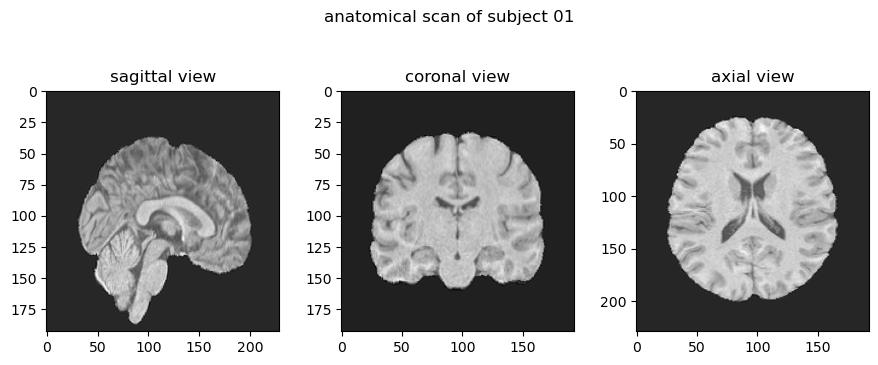

In [10]:
anat_sub_02 = load_data(anat_sub_02_path)
plot_anat(anat_sub_02, "anatomical scan of subject 01")

#### Visualize Func data

In [8]:
reset_overlays()
func_sub_02_path = load_func_data(subject, "001")
load(func_sub_02_path)

Image(sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold, /home/opetit/Desktop/MyFiles/NSSP/miniproject_icafunc_bold/derivatives/sub-02/func/sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz)

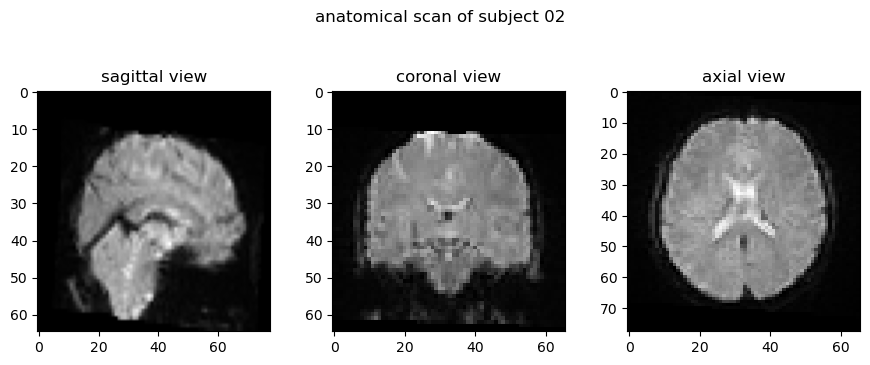

In [9]:
func_sub_02 = load_data(func_sub_02_path)
plot_anat(func_sub_02[:,:,:,121], "anatomical scan of subject 02")

In [10]:
func_sub_16_path = load_func_data("16", "001")
func_sub_16 = load_data(func_sub_16_path)
func_sub_16.shape

(66, 78, 65, 242)

In [11]:
66*78*65*242

80978040

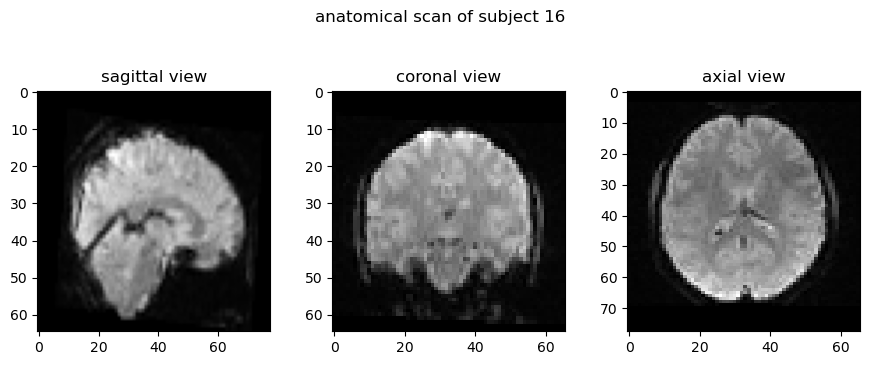

In [12]:
plot_anat(func_sub_16[:,:,:,121], "anatomical scan of subject 16")

#### same shape, seem to be align, what does align realy mean ??

In [37]:
# What is the type of the event data ?= .tsv ???? Do not know how to load it and what is it for
event_sub_02_path = load_event(subject, "001")
    
event_sub_02 = load_data_event(event_sub_02_path)
#Shape (21, 3)
#event_sub_02.shape
#Type pandas.core.frame.DataFrame
#type(event_sub_02)


#Display DataFrame values
pd.set_option("display.max.columns", None)
event_sub_02.head(event_sub_02.shape[0])
#event_sub_02.shape[0] is necessary to plot every rows, by default only the first 5 are plotted


,onset,duration,trail_type
0,0,120,full_circular_checkerboard
1,120,16,white_fixation
2,136,32,full_circular_checkerboard
3,168,16,white_fixation
4,184,32,full_circular_checkerboard
5,216,16,white_fixation
6,232,32,full_circular_checkerboard
7,264,16,white_fixation
8,280,32,full_circular_checkerboard
9,312,16,white_fixation


### 2) Apply group ICA 

In [14]:
# Prepare data

path_func_img = func_sub_02_path
img_ex = nib.load(path_func_img)

# Get affine transform -- check nibabel library for more info!
affine = nib.load(path_func_img).affine
x,y,z,v = img_ex.shape
print(x,y,z,v)

N_vol=242
N_subj=3 ## my computer cant do more than 1 sorryyy 
N_tot=N_vol*N_subj

#* Initialize X
size = x*y*z
X = np.zeros((N_tot,size)) # total_timepoints(2subj*242timepoints) x voxel_num
i = 0
n_nii  = 0
nb_subj_counted=0
for root, dirs, files in sorted(os.walk('/home/challier/Desktop/MyFiles/My_Documents/NSSP/NSSP/miniproject_icafunc_bold/derivatives/sub-02/')):
    if len(files)!= 0:
        nb_subj_counted=nb_subj_counted+1 
        print(f"Loading subject {nb_subj_counted}")
    for j in trange(len(files)):
        file = sorted(files)[j]
        if file.endswith('.nii.gz') and file.partition("run-")[2][0:3] == "001": # do we need to do it for all run ??
            print("file",file)
            if nb_subj_counted<N_subj+1:
                data = nib.load(root+'/'+file).get_fdata().reshape(size, -1).T
                
                #standardize
                row_means = np.mean(data, axis=1).reshape(-1,1)
                row_std = np.std( data, axis = 1).reshape(-1,1)
                data= data - row_means / row_std

                X[n_nii : n_nii + N_vol, :] = data
                n_nii+=N_vol+1

X = zscore(X, axis = 1) # across subjects
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)

66 78 65 242
X matrix size:  (726, 334620)


In [15]:
np.mean(X, axis = 1) #verify normalisation

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,10]#20, 60 ...]


for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    ### YOUR CODE HERE
    ### BEGIN SOLUTION
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    ### END SOLUTION
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components


ValueError: array must not contain infs or NaNs

In [19]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

NameError: name 'S_' is not defined

### 3- Visualization


Dataset created in /home/opetit/nilearn_data/icbm152_2009



Downloaded 33669120 of 63027871 bytes (53.4%,    0.9s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/opetit/nilearn_data/icbm152_2009/e05b733c275cab0eec856067143c9dc9/download..... done.


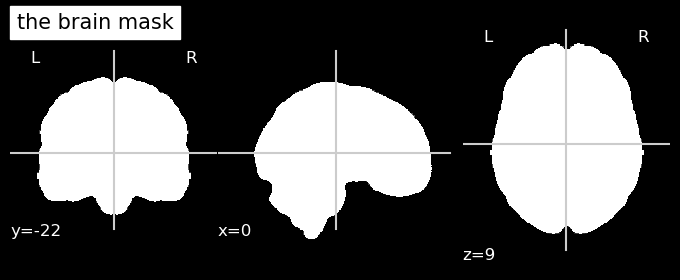

In [20]:
#* Build brain mask to restrict analysis within the brain
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

In [21]:
nb_components[1]

10

In [22]:
S_dict[10]

KeyError: 10

Number of components:  4


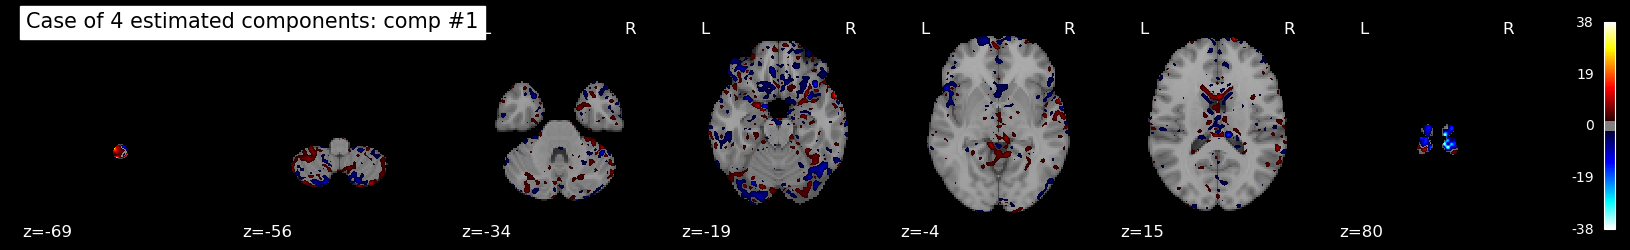

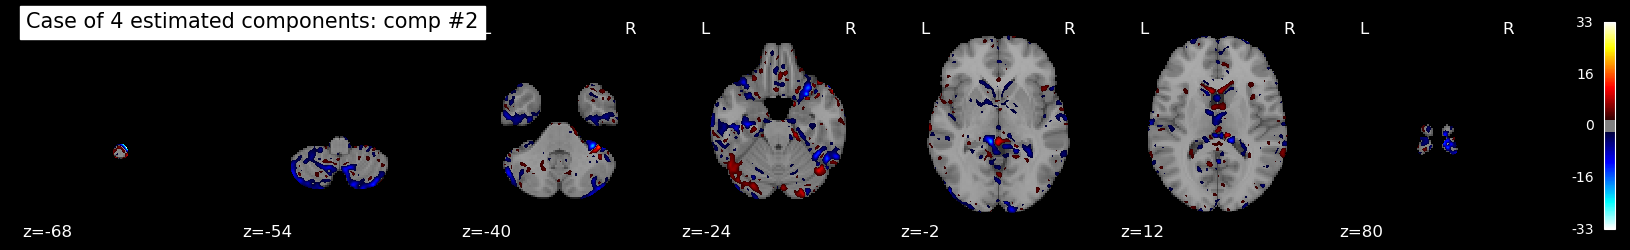

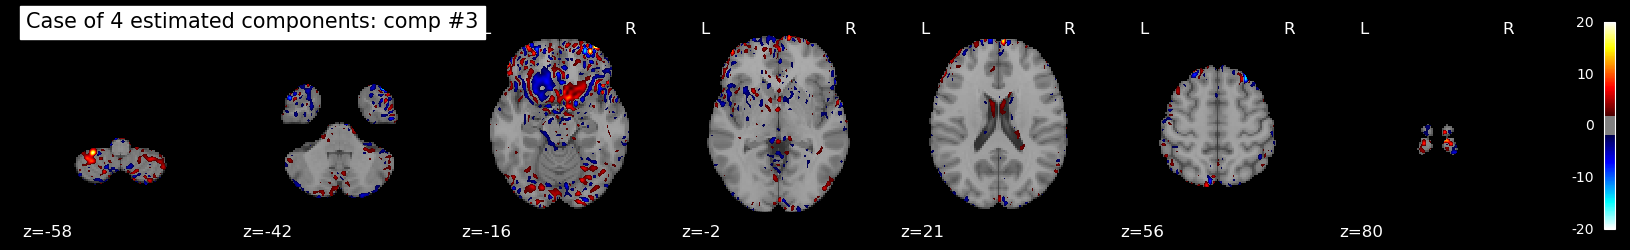

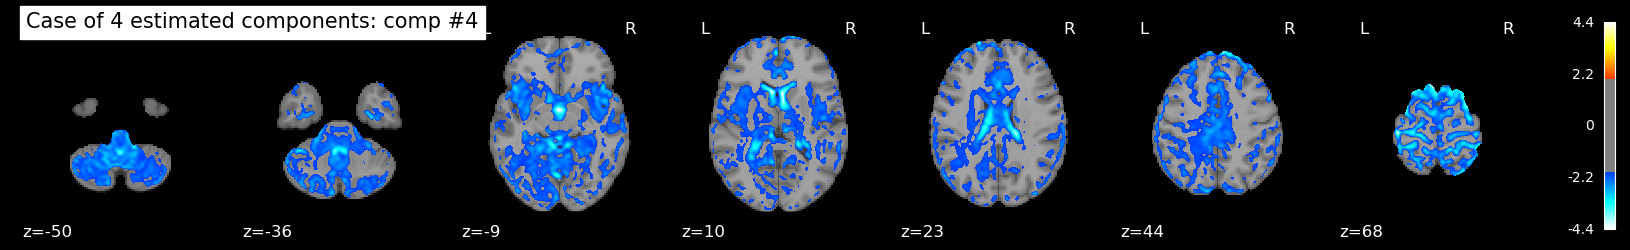

Number of components:  10


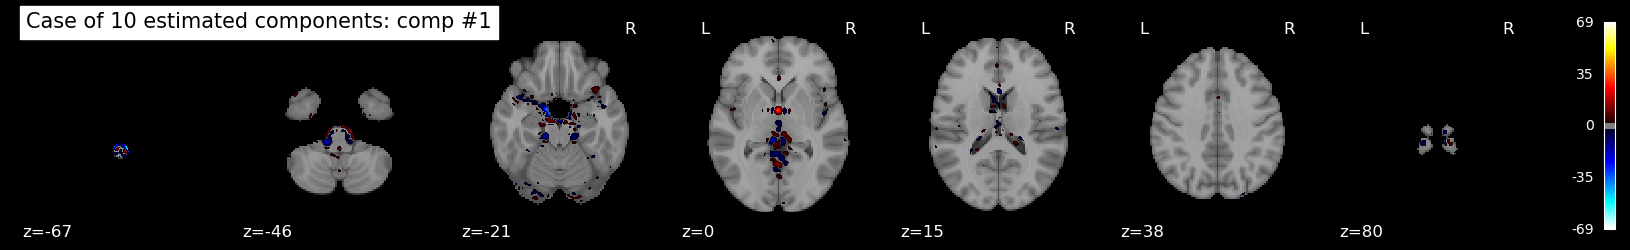

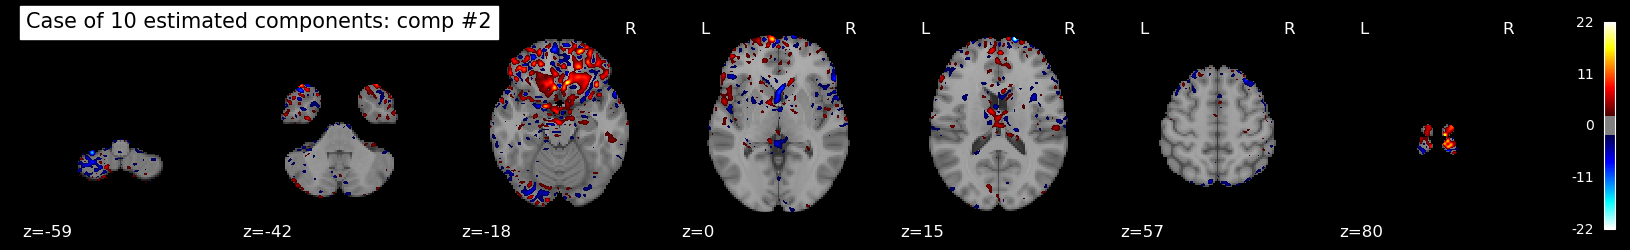

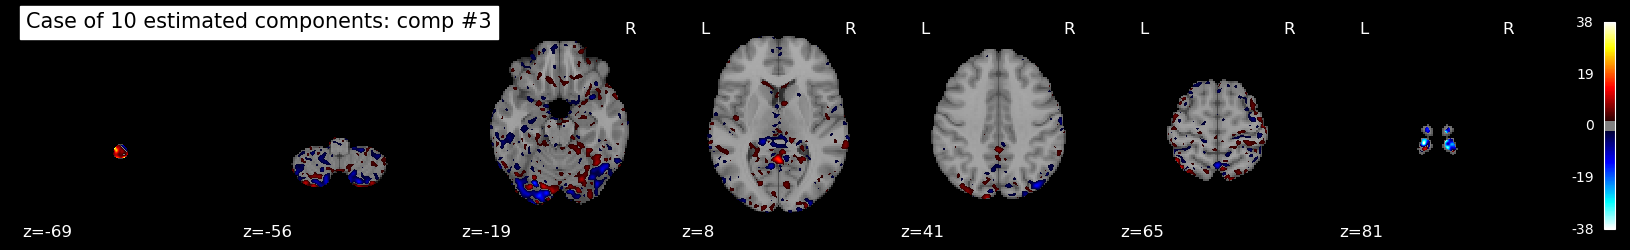

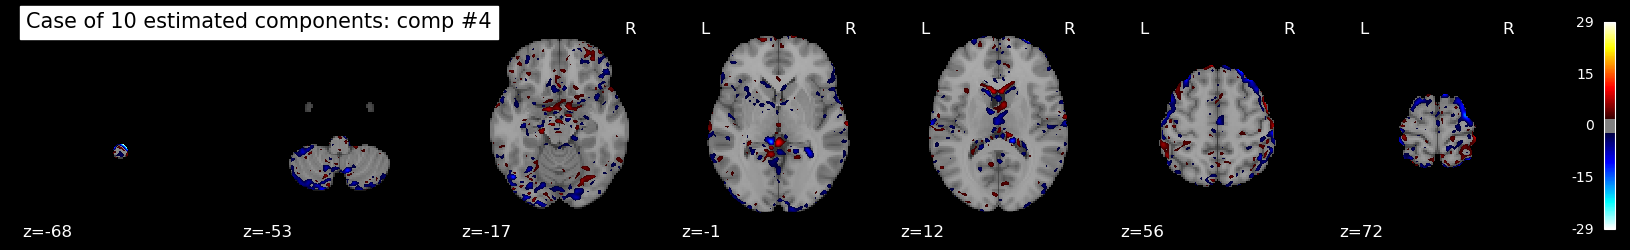

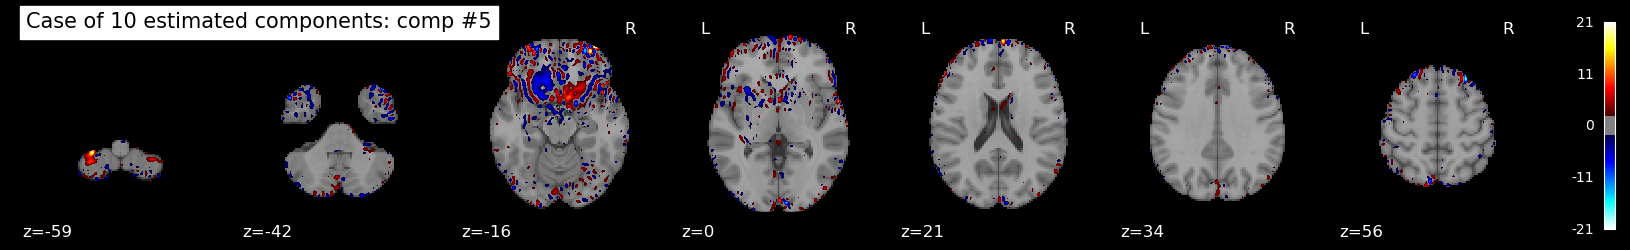

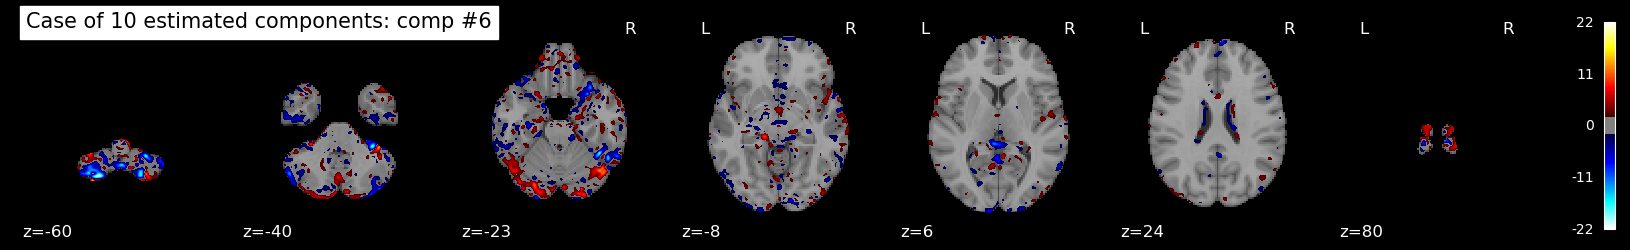

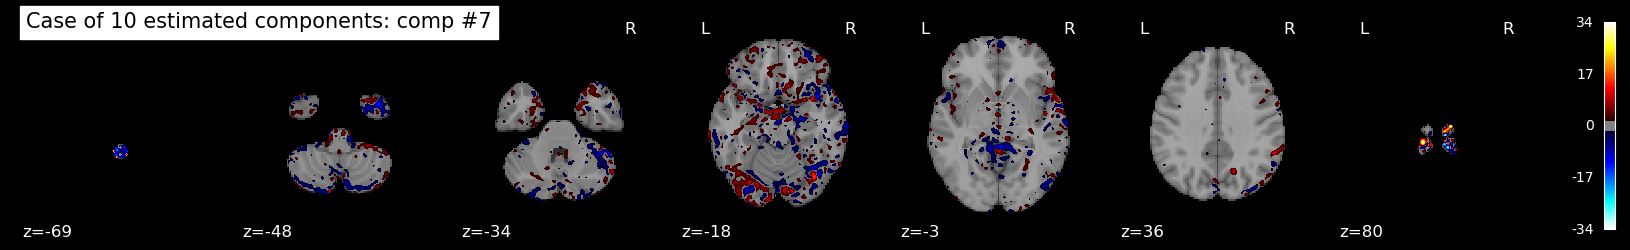

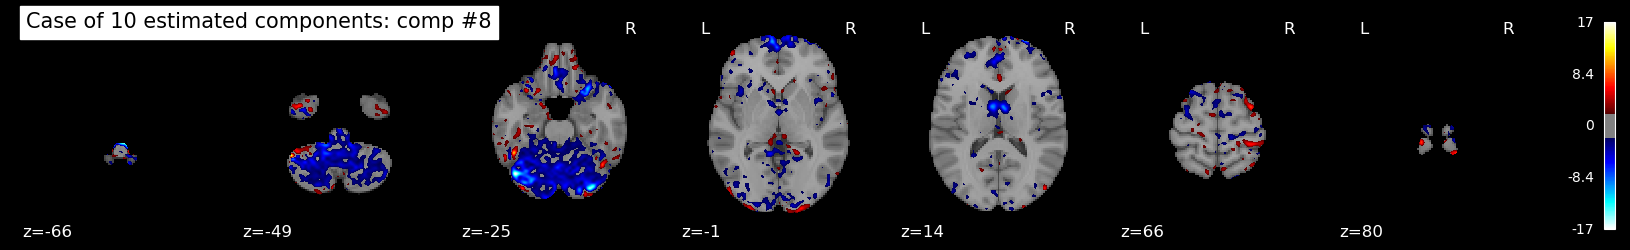

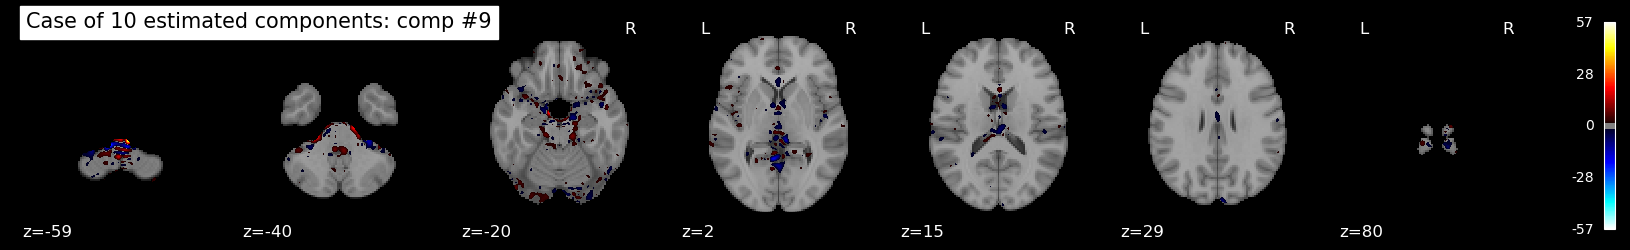

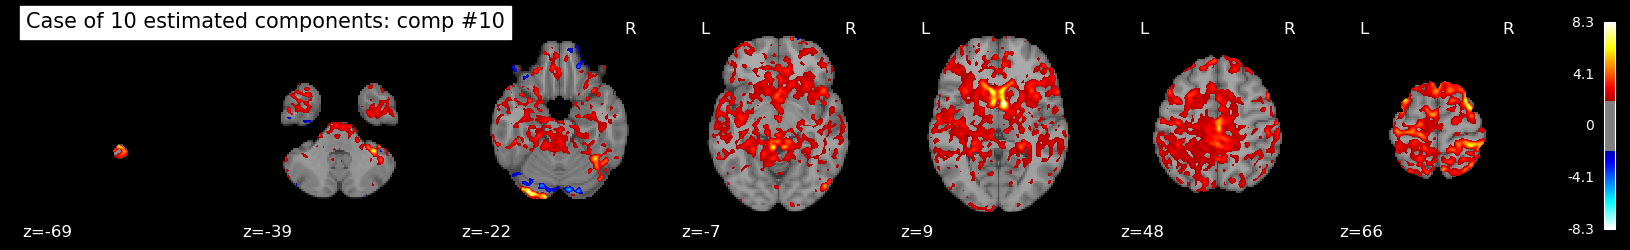

In [43]:
#* Plot the group-level independent components for the different number of requested components.
## Here you can use only 3 components to reduce the plots
## e.g. uncomment this if you used more than 3 values before
# nb_components = nb_components[:3]

def ICA_plot (nb_components, data_dict, mask) :

    for n in nb_components:
        print('Number of components: ',n)
        S_ = data_dict[n].copy()
        for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
            s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
            data = mask.fit_transform(s_img)
            masked_ = masker.inverse_transform(data) # mask the components
            plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                          colorbar=True, black_bg=True, threshold=2*np.std(s),)
                          #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
            plt.show()

ICA_plot(nb_components, S_dict, masker)

In [19]:
# Which background image use ?

Number of components:  4


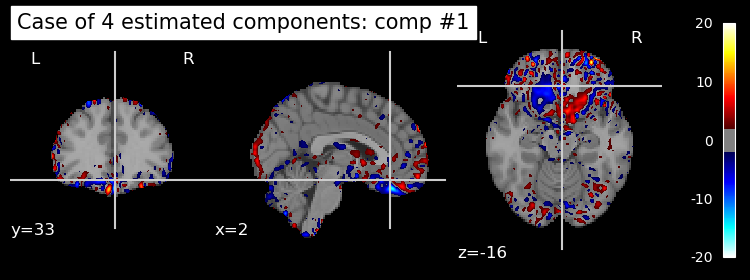

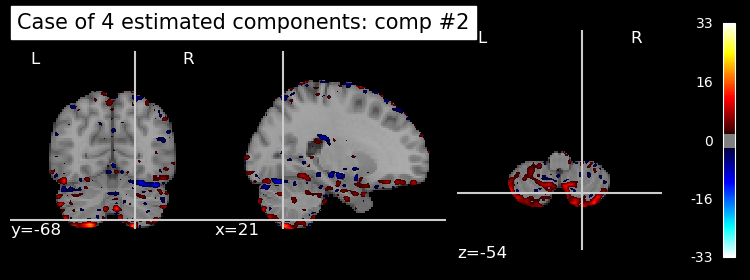

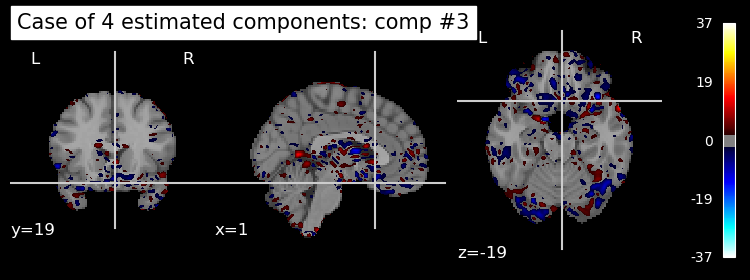

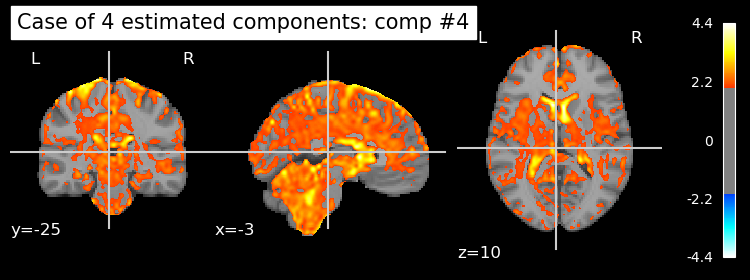

In [17]:
#* Not needed 
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s))
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

### 4- TImeCourse

In [48]:
# Let's visualize the corresponding timecourses when nb_comp=...

timecourse_dict = {}
# As was done in the above visualization, we are interested in voxels above 2 standard deviations
for nbcomp in nb_components :
    associated_timecourses = []
    S_ = S_dict[nbcomp].copy()
    print(f"The number of components you visualize are {nbcomp}")
    for cidx in range(nbcomp):
        threshold = np.std(S_[:,cidx])
        s_comp = np.reshape(S_[:,cidx], (x,y,z))
        thresh_mask = s_comp > threshold

        # Original timecourse - prior to PCA which we used to simplify spatial patterns
        t_comp = X.reshape(N_tot, x,y,z)[:,thresh_mask].mean(axis=1) # Averaging voxel-wise for a single representative timecourse
        associated_timecourses.append(t_comp)
    timecourse_dict[nbcomp] = associated_timecourses



4
The number of components you visualize are 4
10
The number of components you visualize are 10


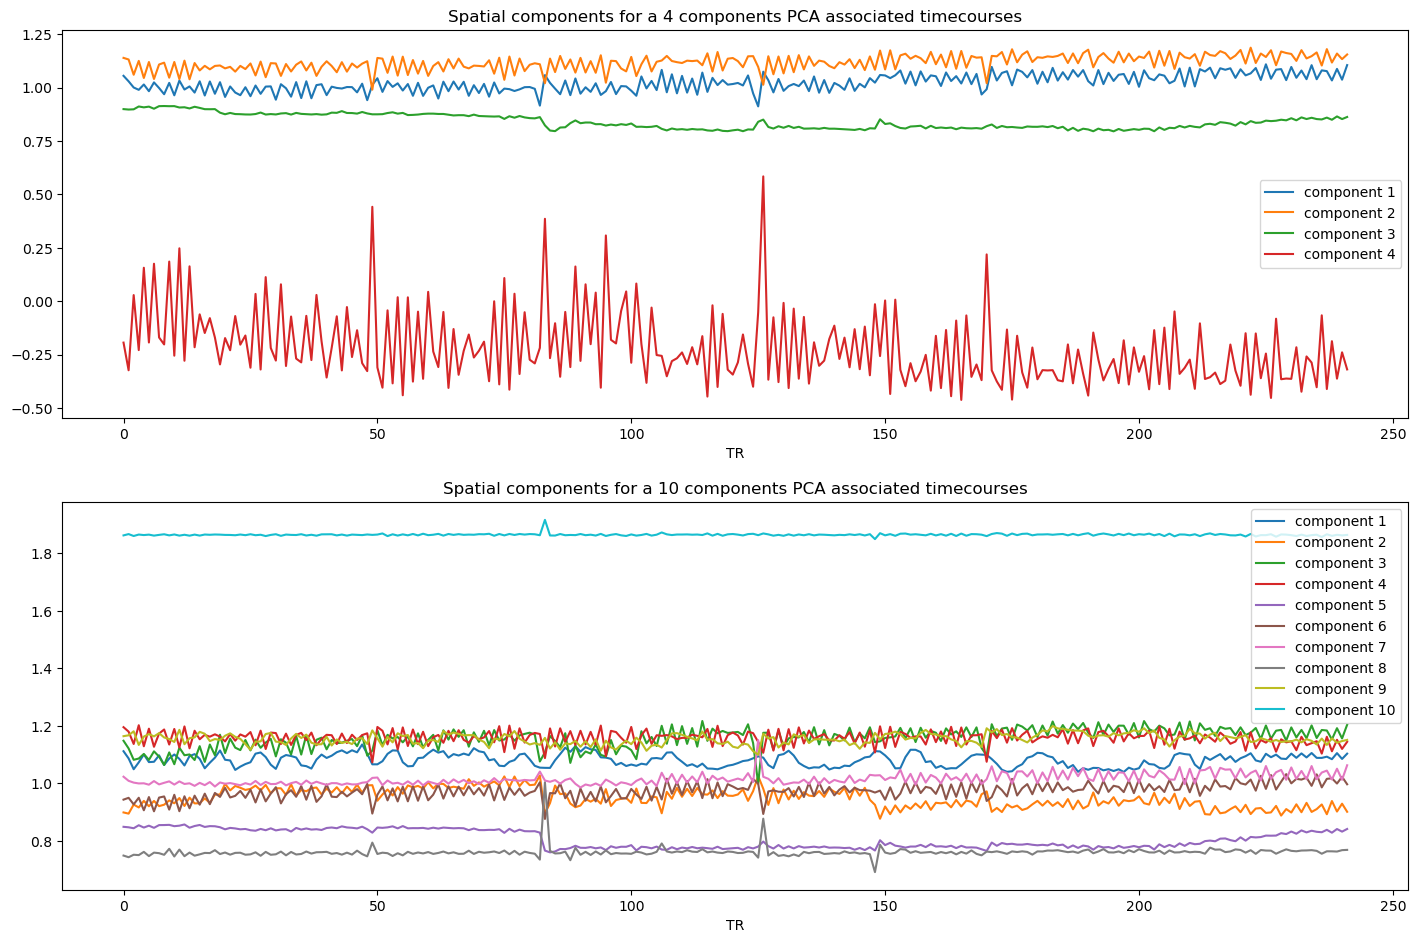

In [64]:
fig, ax = plt.subplots(2, figsize=(15,10))
fig.tight_layout(pad=4.0)

for i, nbcomp in enumerate(nb_components) : 
    assoc_timecourses = timecourse_dict[nbcomp]
    for cidx in range(nbcomp):
        ax[i].plot(assoc_timecourses[cidx], label=f'component {cidx+1}')

        ax[i].legend()
        ax[i].set_xlabel('TR')
        ax[i].set_title(f'Spatial components for a {nbcomp} components PCA associated timecourses')
plt.show()

In [23]:
#TODO : try with diff component nb

### 5- PCA

### Load the Data

In [11]:
subject = '02' 
pca_path_func_data = load_func_data(subject, "001")
img = nib.load(pca_path_func_data)
data_pca = np.asanyarray(img.dataobj)
data_pca.shape

(66, 78, 65, 242)

In [12]:
vol_shape = data_pca.shape[:-1]
n_vols = data_pca.shape[-1]

In [13]:
N = np.prod(vol_shape)
data_pca = data_pca.reshape((N, n_vols))
# Transpose to 242 by N array
data_pca = data_pca.T
# Calculate the mean across columns
row_means = np.mean(data_pca, axis=1)
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
# Subtract the means for each row, put the result into X
X = data_pca - row_means
print(X.shape)

(242, 334620)


In [20]:
# Compute the covariance matrix 
covariance_matrix = X.dot(X.T)

# Apply SVD to get U, S, VT matrices from covariance matrix
U, S, VT = np.linalg.svd(covariance_matrix)
print(U.shape)
print(n_vols)

(242, 242)
242


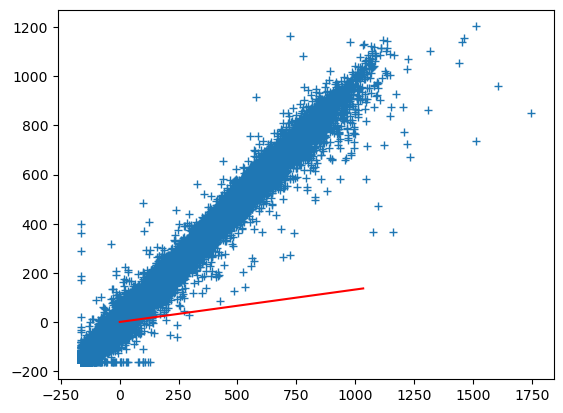

In [15]:
# Plot line corresponding to a scaled version of the first principal component
plt.plot(X[0], X[1], '+')
scaled_u = U[0, :] * -16000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r')

In [16]:
C = U.T.dot(data_pca)
C.shape

(242, 334620)

In [17]:
# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(vol_shape + (n_vols,))
C_vols.shape

#- Break 4D array into two 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

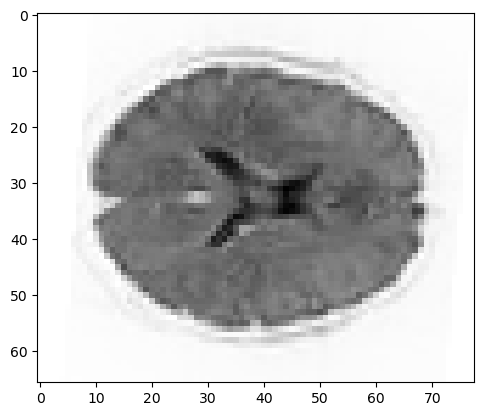

In [18]:
plt.imshow(vol0[:, :, 32], cmap='gray')

In [57]:
def PCA_defined_variance(U, data_pca, threshold):
    #calculate the number of eigenvectors needed to explain chosen variance
    num_eigenvectors = int(np.floor(U.shape[1] * threshold))
    print(num_eigenvectors)
    U_less_variance = U[:, :num_eigenvectors]
    print(U_less_variance.shape)
    C = U_less_variance.T.dot(data_pca)
    print(C.shape)
    
    # Transpose C
    # Reshape the first dimension of C to have the 3D shape of the original data volumes.
    C_vols = C.T.reshape(vol_shape + (num_eigenvectors,))
    C_vols.shape

    #- Break 4D array into two 3D volumes
    vol0 = C_vols[..., 0]
    vol1 = C_vols[..., 1]
    plt.imshow(vol0[:, :, 32], cmap='gray')
    
    

#### Apply PCA for 25 % Variance explained

60
(242, 60)
(60, 334620)


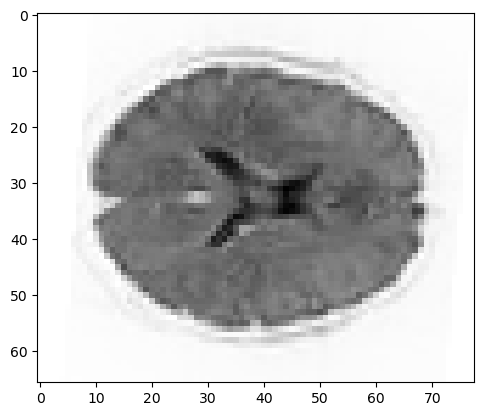

In [58]:
PCA_defined_variance(U, data_pca, 0.25)

121
(242, 121)
(121, 334620)


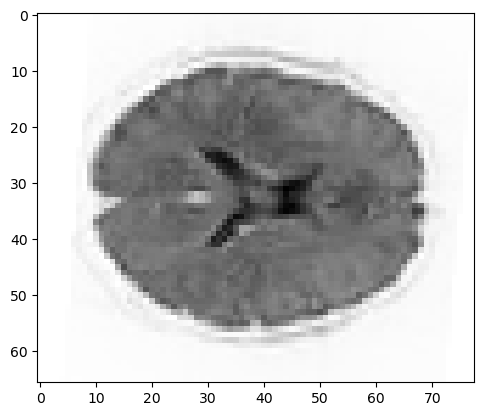

In [59]:
PCA_defined_variance(U, data_pca, 0.5)

229
(242, 229)
(229, 334620)


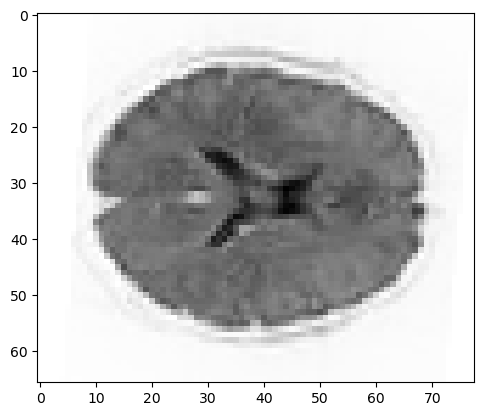

In [60]:
PCA_defined_variance(U, data_pca, 0.95)

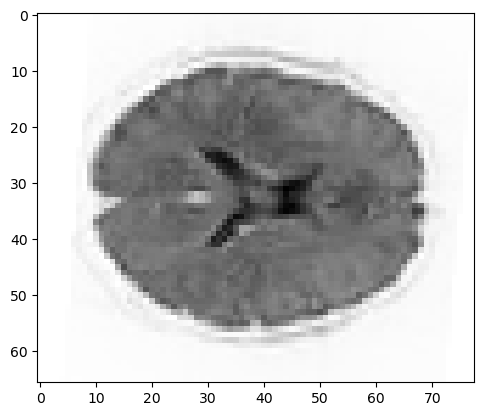